In [1]:
from ipynb.fs.full.feature_engineering_final import X_Transformer
from ipynb.fs.full.feature_engineering_final import DataLoader
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline
from xgboost import plot_tree
from matplotlib.pylab import rcParams

In [2]:
data_loader_train = DataLoader("train.csv")

In [3]:
X_train = data_loader_train.getX()
Y_train = data_loader_train.getY()

In [4]:
x_transformer = X_Transformer()

In [5]:
xgb_regressor = XGBRegressor(objective='reg:squarederror',eval_metric = 'rmse',learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

In [6]:
drop1 = ['Street','LotShape','LandContour',
            'LotConfig','LandSlope','Neighborhood',
            'Condition1','Condition2','BldgType','HouseStyle',
            'RoofStyle','RoofMatl',
            'ExterQual','ExterCond','Foundation','Heating','HeatingQC',
            'CentralAir',
            'PavedDrive','SaleCondition']
drop2 = ['Alley','BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1',
                                           'BsmtFinType2','FireplaceQu','GarageType','GarageQual','GarageFinish',
                                           'GarageCond','PoolQC','Fence','MiscFeature']
drop3 = ['SaleType','Functional','KitchenQual','Exterior1st','Exterior2nd','Utilities','MSZoning','MasVnrType','Electrical']
test_data = pd.read_csv('test.csv')
X_test = test_data.drop(['Id','Utilities', 'Street', 'PoolQC','Alley','Condition2], axis = 1)
#X_test['LotFrontage'] = X_test.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [7]:
learning_pipeline = Pipeline(steps=[('preprocess', x_transformer),('learn',xgb_regressor)])
learning_pipeline.fit(X_train,y=Y_train)





/home/victor/anaconda3/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/victor/anaconda3/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('categorical_with_missing_values_const',
                                                  PipelineWithFeatureNames(feature_names=['BsmtCond',
                                                                                          'BsmtQual',
                                                                                          'BsmtExposure',
                                                                                          'BsmtFinType1',
                                                                                          'BsmtFinType2',
                                                                                          'FireplaceQu',
                                      

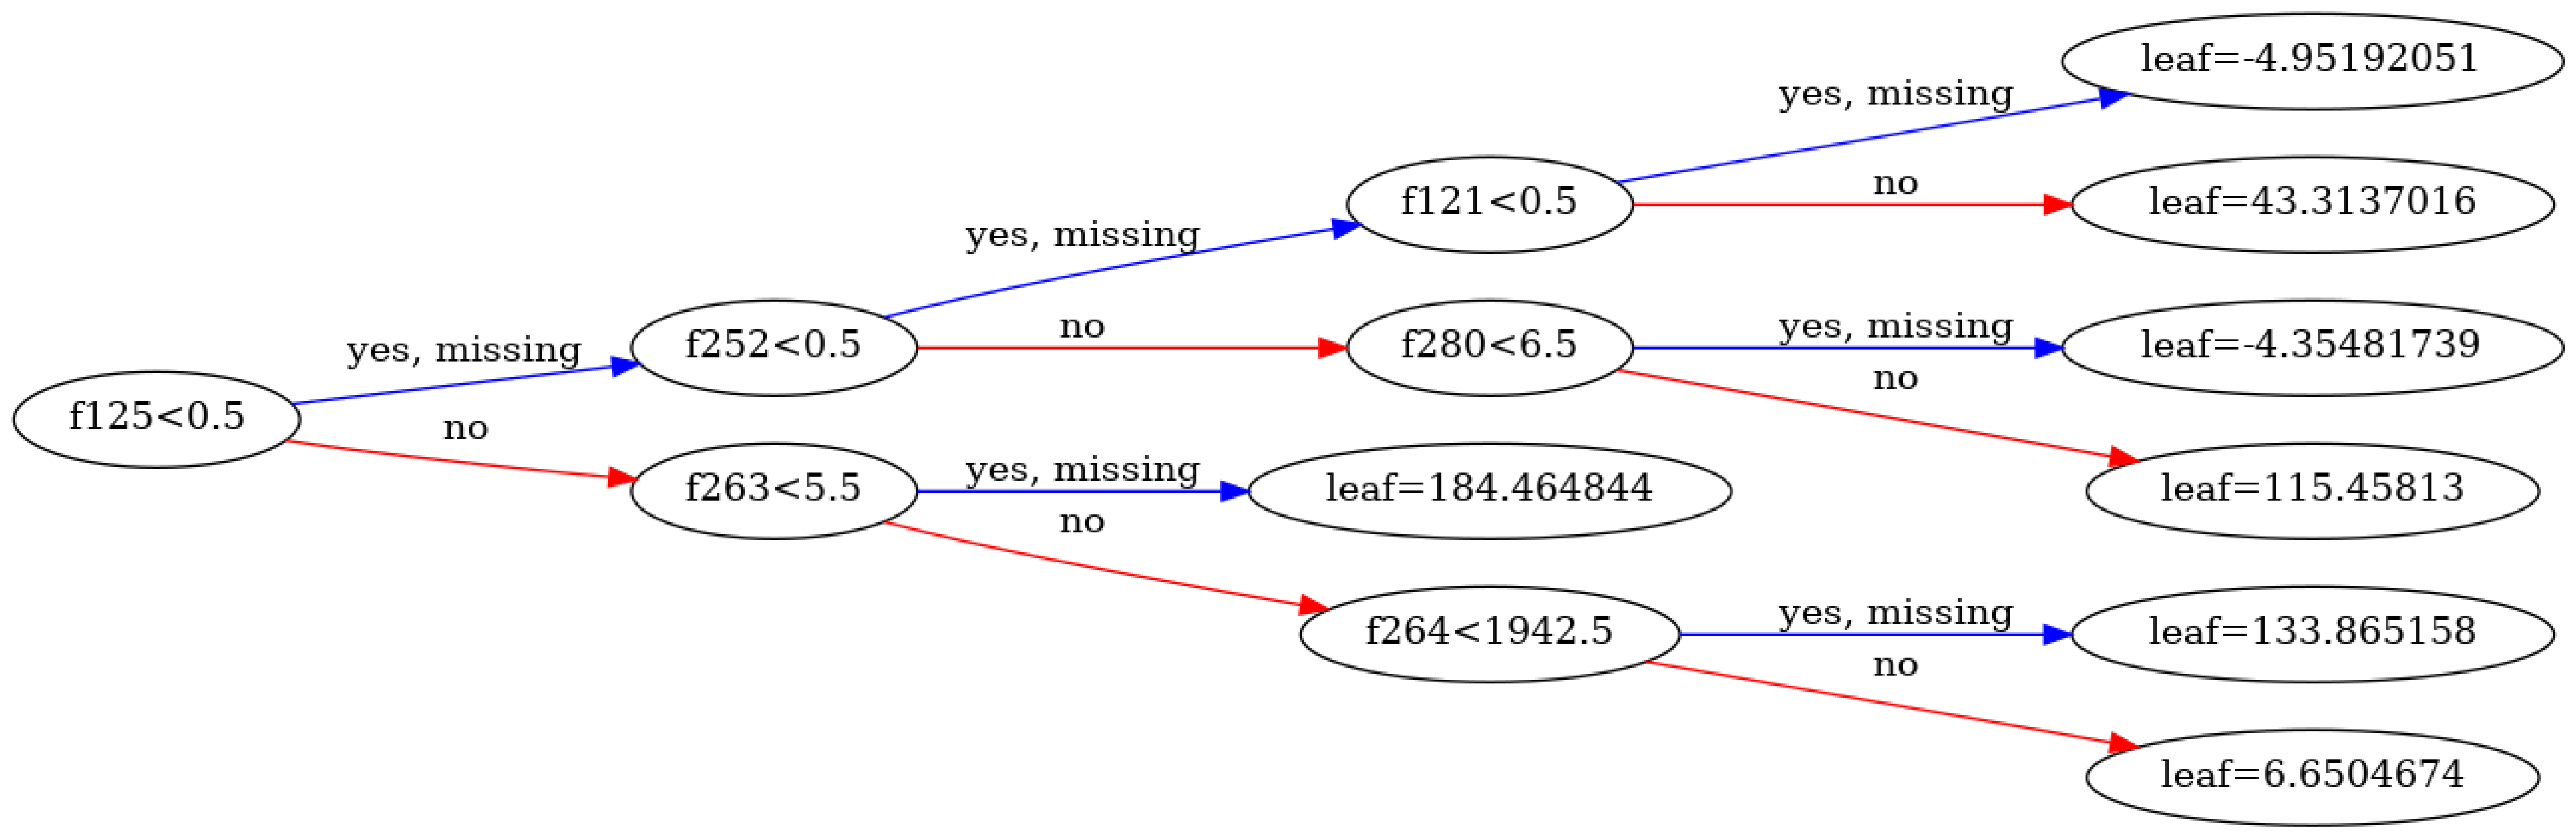

In [8]:
#set up the parameters
rcParams['figure.figsize'] = 100,90
plot_tree(learning_pipeline.named_steps['learn'],num_trees=3459, rankdir='LR')#plt.show()

In [9]:
Ypredicted = learning_pipeline.predict(X_test)

In [10]:
resultDf = pd.DataFrame()
resultDf['Id'] = test_data['Id']
resultDf['SalePrice'] = Ypredicted
resultDf
resultDf.to_csv('submission.csv',index = False)